<a href="https://colab.research.google.com/github/immangwu/GWU/blob/main/jesus_asme_hack_autodesk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install trimesh

In [ ]:
!pip install trimesh rtree

In [ ]:
!pip install openai
!pip install matplotlib
!pip install backoff

In [ ]:
import openai
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import backoff
import time
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd

load all files

In [ ]:
def get_all_files(directory, pattern):
    return [f for f in Path(directory).glob(pattern)]

In [ ]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install pandas openpyxl PyDrive

In [ ]:
input_dir = r"/content/drive/MyDrive/jesus_asme_hack_train/Fusion360GalleryDataset_23hackathon_train"     # Change this to the directory where you downloaded the dataset
input_jsons = get_all_files(input_dir, "*/assembly.json")
#input_png = get_all_files(input_dir, "*/assembly.png")
input_jsons

In [ ]:
#test data directory
test_dir = r"/content/drive/MyDrive/jesus_asme_hack_train/Fusion360GalleryDataset_23hackathon_test"     # Change this to the directory where you downloaded the dataset
test_jsons = get_all_files(test_dir, "*/assembly.json")
#input_png = get_all_files(input_dir, "*/assembly.png")
test_jsons

In [ ]:
#test data
assemblies = {}
bodies = []
for test_json in tqdm(test_jsons):
  with open(test_json, "r", encoding="utf-8") as f:
      assembly_data_test = json.load(f)


  for key, value in assembly_data_test['bodies'].items():
    body_id=key;

    name = value['name']

    #material = value['material_category']
    physical_properties=value['physical_properties']
    properties=assembly_data_test["properties"]
    area=physical_properties.get("area")
    volume=physical_properties.get("volume")
    categories=properties.get("categories")
    industries=properties.get("industries")
    #if name[:4] != 'Body':
    bodies.append({'body_id':body_id,'name':name,'area':area,'volume':volume,'categories':categories,'industries':industries})

  if len(bodies) > 0:
    assemblies[test_json.parts[-2]] = bodies
#prepate input and output datasets
test_body_id=[] #00
name=[]   #01
area=[] #02
volume=[] #03
categories=[] #04
industries=[] #05
#material=[] #op 01

for x in range(len(bodies)):
  test_body_id.append(bodies[x]["body_id"])
  name.append(bodies[x]["name"])
  area.append(bodies[x]["area"])
  volume.append(bodies[x]["volume"])
  categories.append(bodies[x]["categories"])
  industries.append(bodies[x]["industries"])
  #material.append(bodies[x]["material"])

test = {
    'body_id' : test_body_id,
    'name' : name,
    'area' : area,
    'volume' : volume,
    'categories' : categories,
    'industries' : industries,
    #'#material' : material,
}
test = pd.DataFrame(test)
#convert the list type data to string type data
test['categories'] = [','.join(map(str, l)) for l in test['categories']]
test['industries'] = [','.join(map(str, l)) for l in test['industries']]
test
#assembly_data
#bodies

In [ ]:
from google.colab import files

In [ ]:
assemblies = {}
bodies = []
for input_json in tqdm(input_jsons):
  with open(input_json, "r", encoding="utf-8") as f:
      assembly_data = json.load(f)


  for key, value in assembly_data['bodies'].items():
    body_id=key;

    name = value['name']

    material = value['material_category']
    physical_properties=value['physical_properties']
    properties=assembly_data["properties"]
    area=physical_properties.get("area")
    volume=physical_properties.get("volume")
    categories=properties.get("categories")
    industries=properties.get("industries")
    if name[:4] != 'Body':
      bodies.append({'body_id':body_id,'name':name, 'material':material,'area':area,'volume':volume,'categories':categories,'industries':industries})

  if len(bodies) > 0:
    assemblies[input_json.parts[-2]] = bodies
#prepate input and output datasets
body_id=[] #00
name=[]   #01
area=[] #02
volume=[] #03
categories=[] #04
industries=[] #05
material=[] #op 01

for x in range(len(bodies)):
  body_id.append(bodies[x]["body_id"])
  name.append(bodies[x]["name"])
  area.append(bodies[x]["area"])
  volume.append(bodies[x]["volume"])
  categories.append(bodies[x]["categories"])
  industries.append(bodies[x]["industries"])
  material.append(bodies[x]["material"])

input = {
    'body_id' : body_id,
    'name' : name,
    'area' : area,
    'volume' : volume,
    'categories' : categories,
    'industries' : industries,
    'material' : material,
}
input = pd.DataFrame(input)
#convert the list type data to string type data
input['categories'] = [','.join(map(str, l)) for l in input['categories']]
input['industries'] = [','.join(map(str, l)) for l in input['industries']]
#input
#assembly_data
#bodies
type(body_id)

100%|██████████| 676/676 [02:49<00:00,  3.98it/s]


list

In [ ]:
#input
import os
import trimesh
import numpy as np
from scipy.spatial import cKDTree
app_thickness=[]
def calculate_approximate_thickness(mesh):
    # Sample points on one side of the mesh (e.g., based on bounding box)
    bbox_min, bbox_max = mesh.bounds
    num_points = 1000
    points = np.random.uniform(bbox_min, bbox_max, (num_points, 3))

    # Create a KD-tree for the mesh vertices
    tree = cKDTree(mesh.vertices)

    # Find nearest vertices on the other side of the mesh
    _, nearest_indices = tree.query(points)
    nearest_vertices = mesh.vertices[nearest_indices]

    # Calculate distances between the sampled points and their nearest vertices
    distances = np.linalg.norm(points - nearest_vertices, axis=1)

    # Calculate and return average thickness
    average_thickness = np.mean(distances)
    return average_thickness
#aspect ratio
def calculate_average_aspect_ratio_and_skewness(mesh):
    total_aspect_ratio = 0.0
    total_skewness = 0.0
    num_triangles = len(mesh.faces)

    for face in mesh.faces:
        vertices = mesh.vertices[face]

        # Calculate edge lengths
        edge_lengths = [np.linalg.norm(vertices[(i + 1) % 3] - vertices[i]) for i in range(3)]

        # Calculate aspect ratio
        max_edge_length = max(edge_lengths)
        min_edge_length = min(edge_lengths)
        aspect_ratio = max_edge_length / min_edge_length
        total_aspect_ratio += aspect_ratio

        # Calculate skewness
        ordered_edge_lengths = sorted(edge_lengths)
        skewness = (ordered_edge_lengths[2] - ordered_edge_lengths[0]) / ordered_edge_lengths[1]
        total_skewness += skewness

    average_aspect_ratio = total_aspect_ratio / num_triangles
    average_skewness = total_skewness / num_triangles

    return average_aspect_ratio, average_skewness


#read all obj files

import os
import trimesh

# Specify the base directory where the subfolders containing OBJ files are located
base_dir = "/content/drive/MyDrive/jesus_asme_hack_train/Fusion360GalleryDataset_23hackathon_train"
aar=[];
skew=[];
chi_eu=[];
# Iterate through each subfolder
for subfolder_name in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Iterate through body IDs
        for j in body_id:
            # Construct the file path within the subfolder
            file_name = j + ".obj"  # No need to add .obj if body_id already has it
            obj_file_path = os.path.join(subfolder_path, file_name)

            # Check if the file exists
            if os.path.exists(obj_file_path):
                # Load the OBJ mesh
                mesh = trimesh.load(obj_file_path)
                # Specify the input file path
                input_file = obj_file_path
                # Calculate the approximate average thickness
                average_thickness = calculate_approximate_thickness(mesh)
                app_thickness.append(average_thickness)
                # Print the result
                print("Subfolder:", subfolder_name)
                print("Body ID:", j)
                print("Approximate Average Thickness:", average_thickness)
                avg_aspect_ratio, avg_skewness = calculate_average_aspect_ratio_and_skewness(mesh)
                aar.append(avg_aspect_ratio)
                skew.append(avg_skewness)
                print("Average Aspect Ratio:", avg_aspect_ratio)
                print("Average Skewness:", avg_skewness)
                chi = mesh.vertices.shape[0] - mesh.edges.shape[0] + mesh.faces.shape[0]
                chi_eu.append(chi)
                print("Euler's Characteristic:", chi)

            else:
                print("File not found:", obj_file_path)
input['Average Aspect Ratio'] = aar
input['Average Skewness'] = skew
input['app_thickness'] = app_thickness
input['chi_eu'] = chi_eu

excel_filename = "data.xlsx"
input.to_excel(excel_filename, index=False, engine="openpyxl")
from google.colab import files
# Download the Excel file
files.download(excel_filename)

In [ ]:
#test
import os
import trimesh
import numpy as np
from scipy.spatial import cKDTree
app_thickness=[]
def calculate_approximate_thickness(mesh):
    # Sample points on one side of the mesh (e.g., based on bounding box)
    bbox_min, bbox_max = mesh.bounds
    num_points = 1000
    points = np.random.uniform(bbox_min, bbox_max, (num_points, 3))

    # Create a KD-tree for the mesh vertices
    tree = cKDTree(mesh.vertices)

    # Find nearest vertices on the other side of the mesh
    _, nearest_indices = tree.query(points)
    nearest_vertices = mesh.vertices[nearest_indices]

    # Calculate distances between the sampled points and their nearest vertices
    distances = np.linalg.norm(points - nearest_vertices, axis=1)

    # Calculate and return average thickness
    average_thickness = np.mean(distances)
    return average_thickness
#aspect ratio
def calculate_average_aspect_ratio_and_skewness(mesh):
    total_aspect_ratio = 0.0
    total_skewness = 0.0
    num_triangles = len(mesh.faces)

    for face in mesh.faces:
        vertices = mesh.vertices[face]

        # Calculate edge lengths
        edge_lengths = [np.linalg.norm(vertices[(i + 1) % 3] - vertices[i]) for i in range(3)]

        # Calculate aspect ratio
        max_edge_length = max(edge_lengths)
        min_edge_length = min(edge_lengths)
        aspect_ratio = max_edge_length / min_edge_length
        total_aspect_ratio += aspect_ratio

        # Calculate skewness
        ordered_edge_lengths = sorted(edge_lengths)
        skewness = (ordered_edge_lengths[2] - ordered_edge_lengths[0]) / ordered_edge_lengths[1]
        total_skewness += skewness

    average_aspect_ratio = total_aspect_ratio / num_triangles
    average_skewness = total_skewness / num_triangles

    return average_aspect_ratio, average_skewness


#read all obj files

import os
import trimesh

# Specify the base directory where the subfolders containing OBJ files are located
base_dir = "/content/drive/MyDrive/jesus_asme_hack_train/Fusion360GalleryDataset_23hackathon_test"
aar=[];
skew=[];
chi_eu=[];
# Iterate through each subfolder
for subfolder_name in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Iterate through body IDs
        for j in test_body_id:
            # Construct the file path within the subfolder
            file_name = j + ".obj"  # No need to add .obj if body_id already has it
            obj_file_path = os.path.join(subfolder_path, file_name)

            # Check if the file exists
            if os.path.exists(obj_file_path):
                # Load the OBJ mesh
                mesh = trimesh.load(obj_file_path)
                # Specify the input file path
                input_file = obj_file_path
                # Calculate the approximate average thickness
                average_thickness = calculate_approximate_thickness(mesh)
                app_thickness.append(average_thickness)
                # Print the result
                print("Subfolder:", subfolder_name)
                print("Body ID:", j)
                print("Approximate Average Thickness:", average_thickness)
                avg_aspect_ratio, avg_skewness = calculate_average_aspect_ratio_and_skewness(mesh)
                aar.append(avg_aspect_ratio)
                skew.append(avg_skewness)
                print("Average Aspect Ratio:", avg_aspect_ratio)
                print("Average Skewness:", avg_skewness)
                chi = mesh.vertices.shape[0] - mesh.edges.shape[0] + mesh.faces.shape[0]
                chi_eu.append(chi)
                print("Euler's Characteristic:", chi)

            else:
                print("File not found:", obj_file_path)
test['Average Aspect Ratio'] = aar
test['Average Skewness'] = skew
test['app_thickness'] = app_thickness
test['chi_eu'] = chi_eu

excel_filename = "data1.xlsx"
test.to_excel(excel_filename, index=False, engine="openpyxl")
from google.colab import files
# Download the Excel file
files.download(excel_filename)

In [ ]:
excel_filename = "data.xlsx"
input.to_excel(excel_filename, index=False, engine="openpyxl")
from google.colab import files
# Download the Excel file
files.download(excel_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [ ]:
#cLASSIFICATION ALGORITHM
input.groupby('material').count()
#Check for null values
#print(input.isnull().sum())
#Check data types
#input.dtypes

In [ ]:
#inpur for train and test data split
y_input = pd.DataFrame()
decoded_data = pd.DataFrame()
X_input = input.drop(['body_id','material'],axis=1)
#data from the test
X_test = test.drop(['body_id'],axis=1)
X=pd.concat([X_input, X_test], ignore_index=True)
y_input['material'] = input['material']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X["name"] = le.fit_transform(X["name"])
X["categories"] = le.fit_transform(X["categories"])
X["industries"] = le.fit_transform(X["industries"])
y_input['material'] = le.fit_transform(y_input['material'])
largest_number = X['volume'].max()
#print(largest_number)
#once aain split the input data for train and test
split_index=X_input.index[-1]
split_index=split_index+1
X_input_train  = X.iloc[:split_index]
X_input_test = X.iloc[split_index:]
print(split_index)
#y_input
decoded_data['decode'] = le.inverse_transform(y_input['material'])
material=pd.concat([y_input, decoded_data], axis=1)
#decoded_data
#goin to network
print(y_input)
#X_input_test
material = material.drop_duplicates()
material=material.sort_values(by='material')
#print(test)

def get_adjacent_value(data_frame, search_column, search_value, adjacent_column):
    """
    Check if a DataFrame contains a specific value in a given column.
    If found, return the value in the adjacent column.
    """
    if search_value in data_frame[search_column].values:
        index = data_frame.index[data_frame[search_column] == search_value].tolist()[0]
        adjacent_value = data_frame.at[index, adjacent_column]
        return adjacent_value
    else:
        return None

# Logistic Regression

In [ ]:
#So, there are object data types and a float type as well. We have to convert these labels to numeric (int64) form,
#so they become machine-readable. This is done through label encoding:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X_input_train,y_input,test_size=0.2,
                                               random_state=42, shuffle=True)

#Data was splitted as 80% train data and 20% test data.

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)
#Feature Scaling
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#print(X_train)
#X_test = sc.fit_transform(X_test)
#Normalizing the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
#y_train = scaler.fit_transform(y_train)
#y_test = scaler.fit_transform(y_test)

#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}
reg = LogisticRegression(random_state = 42)
accuracies = cross_val_score(reg, X_train, y_train, cv=2) #change cv value
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",reg.score(X_test,y_test))
#X_train

In [ ]:
X_input_test = scaler.fit_transform(X_input_test)
y_pred = reg.predict(X_input_test)
y_pred
prediction1=[]
for i in  y_pred:
  search_column="material"
  adjacent_column="decode"
  prediction2=get_adjacent_value(material, search_column, i, adjacent_column)
  row_dict = {'prediction': prediction2}
  prediction1.append(row_dict)
prediction = pd.DataFrame(prediction1)
prediction
concatenated_df = pd.concat([test, prediction], axis=1)
concatenated_df
excel_filename = "predict.xlsx"
concatenated_df.to_excel(excel_filename, index=False, engine="openpyxl")
from google.colab import files
# Download the Excel file
files.download(excel_filename)




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# KNN Classifier

In [ ]:
knn = KNeighborsClassifier()
accuracies = cross_val_score(knn, X_input_train,y_input, cv=3)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn.score(X_test,y_test))
#Store results in the dictionaries
result_dict_train["KNN Train Score"] = np.mean(accuracies)
result_dict_test["KNN Test Score"] = knn.score(X_test,y_test)

Train Score: 0.42545950247198633
Test Score: 0.7269736842105263


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

In [ ]:
X_input_test = scaler.fit_transform(X_input_test)
y_pred = knn.predict(X_input_test)
y_pred
prediction1=[]
for i in  y_pred:
  search_column="material"
  adjacent_column="decode"
  prediction2=get_adjacent_value(material, search_column, i, adjacent_column)
  row_dict = {'prediction': prediction2}
  prediction1.append(row_dict)
prediction = pd.DataFrame(prediction1)
prediction
concatenated_df = pd.concat([test, prediction], axis=1)
concatenated_df

,body_id,name,area,volume,categories,industries,Average Aspect Ratio,Average Skewness,app_thickness,chi_eu,prediction
0,3b4b11d8-05cc-11ec-b54e-064a63348d37,Travesaño Corto_1,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,16.603694,0,Other
1,3b4b6050-05cc-11ec-b9f5-064a63348d37,Travesaño Corto_2,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,15.928175,0,Other
2,3b4baeb6-05cc-11ec-a4c7-064a63348d37,Travesaño Corto_3,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,16.535015,0,Other
3,3b4bd5f0-05cc-11ec-a6d8-064a63348d37,Travesaño Corto_4,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,16.721227,0,Other
4,3b4bfcec-05cc-11ec-bde0-064a63348d37,Travesaño Largo _ 1,1980.387200,2449.543488,Product Design,Product Design & Manufacturing,12.945924,0.770013,23.437046,0,Other
...,...,...,...,...,...,...,...,...,...,...,...
150,ed6be5b4-056b-11ec-a240-0ad8e3c9254f,Body29,0.053721,0.000551,Mechanical Engineering,Product Design & Manufacturing,6.130927,0.815942,0.019241,-280,Metal_Ferrous_Steel
151,ed6c33ba-056b-11ec-9d04-0ad8e3c9254f,Body30,4.049367,0.239289,Mechanical Engineering,Product Design & Manufacturing,2.342012,0.517798,0.124258,-791,Metal_Non-Ferrous
152,ed6ca8e4-056b-11ec-97c8-0ad8e3c9254f,Body31,0.146376,0.002160,Mechanical Engineering,Product Design & Manufacturing,12.819286,0.701524,0.058730,-194,Plastic
153,ed6cf724-056b-11ec-8f8c-0ad8e3c9254f,Body32,0.053721,0.000551,Mechanical Engineering,Product Design & Manufacturing,6.130927,0.815942,0.019817,-280,Metal_Ferrous_Steel


# Support Vector Classifier

In [ ]:
svc = SVC(random_state = 42)
accuracies = cross_val_score(svc, X_input_train,y_input, cv=2)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X_test,y_test))
#Store results in the dictionaries
result_dict_train["SVM Train Score"] = np.mean(accuracies)
result_dict_test["SVM Test Score"] = svc.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Score: 0.37730870712401055
Test Score: 0.5394736842105263


In [ ]:
X_input_test = scaler.fit_transform(X_input_test)
y_pred = svc.predict(X_input_test)
y_pred
prediction1=[]
for i in  y_pred:
  search_column="material"
  adjacent_column="decode"
  prediction2=get_adjacent_value(material, search_column, i, adjacent_column)
  row_dict = {'prediction': prediction2}
  prediction1.append(row_dict)
prediction = pd.DataFrame(prediction1)
prediction
concatenated_df = pd.concat([test, prediction], axis=1)
concatenated_df

,body_id,name,area,volume,categories,industries,Average Aspect Ratio,Average Skewness,app_thickness,chi_eu,prediction
0,3b4b11d8-05cc-11ec-b54e-064a63348d37,Travesaño Corto_1,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,16.603694,0,Other
1,3b4b6050-05cc-11ec-b9f5-064a63348d37,Travesaño Corto_2,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,15.928175,0,Other
2,3b4baeb6-05cc-11ec-a4c7-064a63348d37,Travesaño Corto_3,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,16.535015,0,Other
3,3b4bd5f0-05cc-11ec-a6d8-064a63348d37,Travesaño Corto_4,1370.787200,1675.351488,Product Design,Product Design & Manufacturing,9.017133,0.754609,16.721227,0,Other
4,3b4bfcec-05cc-11ec-bde0-064a63348d37,Travesaño Largo _ 1,1980.387200,2449.543488,Product Design,Product Design & Manufacturing,12.945924,0.770013,23.437046,0,Other
...,...,...,...,...,...,...,...,...,...,...,...
150,ed6be5b4-056b-11ec-a240-0ad8e3c9254f,Body29,0.053721,0.000551,Mechanical Engineering,Product Design & Manufacturing,6.130927,0.815942,0.019241,-280,Plastic
151,ed6c33ba-056b-11ec-9d04-0ad8e3c9254f,Body30,4.049367,0.239289,Mechanical Engineering,Product Design & Manufacturing,2.342012,0.517798,0.124258,-791,Metal_Non-Ferrous
152,ed6ca8e4-056b-11ec-97c8-0ad8e3c9254f,Body31,0.146376,0.002160,Mechanical Engineering,Product Design & Manufacturing,12.819286,0.701524,0.058730,-194,Metal_Non-Ferrous
153,ed6cf724-056b-11ec-8f8c-0ad8e3c9254f,Body32,0.053721,0.000551,Mechanical Engineering,Product Design & Manufacturing,6.130927,0.815942,0.019817,-280,Plastic


# Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier(random_state = 42)
accuracies = cross_val_score(dtc, X_input_train,y_input, cv=2)
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",dtc.score(X_test,y_test))
#Store results in the dictionaries
result_dict_train["Decision Tree Train Score"] = np.mean(accuracies)
result_dict_test["Decision Tree Test Score"] = dtc.score(X_test,y_test)

Train Score: 0.20316622691292877
Test Score: 0.6282894736842105


In [ ]:
X_input_test = scaler.fit_transform(X_input_test)
y_pred = dtc.predict(X_input_test)
y_pred
prediction1=[]
for i in  y_pred:
  search_column="material"
  adjacent_column="decode"
  prediction2=get_adjacent_value(material, search_column, i, adjacent_column)
  row_dict = {'prediction': prediction2}
  prediction1.append(row_dict)
prediction = pd.DataFrame(prediction1)
prediction
concatenated_df = pd.concat([test, prediction], axis=1)
concatenated_df

# Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state = 42)
accuracies = cross_val_score(rfc, X_input_train,y_input, cv=2)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",rfc.score(X_test,y_test))
#Store results in the dictionaries
result_dict_train["Random Forest Train Score"] = np.mean(accuracies)
result_dict_test["Random Forest Test Score"] = rfc.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
<ipython-input-72-cdfd4e40d582>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


Train Score: 0.4129287598944591
Test Score: 0.7598684210526315


In [ ]:
X_input_test = scaler.fit_transform(X_input_test)
y_pred = rfc.predict(X_input_test)
y_pred
prediction1=[]
for i in  y_pred:
  search_column="material"
  adjacent_column="decode"
  prediction2=get_adjacent_value(material, search_column, i, adjacent_column)
  row_dict = {'prediction': prediction2}
  prediction1.append(row_dict)
prediction = pd.DataFrame(prediction1)
prediction
concatenated_df = pd.concat([test, prediction], axis=1)
concatenated_df

# Naïve Bayes Classifier

In [ ]:
gnb = GaussianNB()
accuracies = cross_val_score(gnb, X_input_train,y_input, cv=2)
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",gnb.score(X_test,y_test))
#Store results in the dictionaries
result_dict_train["Gaussian NB Train Score"] = np.mean(accuracies)
result_dict_test["Gaussian NB Test Score"] = gnb.score(X_test,y_test)

In [ ]:
X_input_test = scaler.fit_transform(X_input_test)
y_pred = gnb.predict(X_test_t)
y_pred
prediction1=[]
for i in  y_pred:
  search_column="material"
  adjacent_column="decode"
  prediction2=get_adjacent_value(material, search_column, i, adjacent_column)
  row_dict = {'prediction': prediction2}
  prediction1.append(row_dict)
prediction = pd.DataFrame(prediction1)
prediction
concatenated_df = pd.concat([test, prediction], axis=1)
concatenated_df

# Compare Accuracy Scores

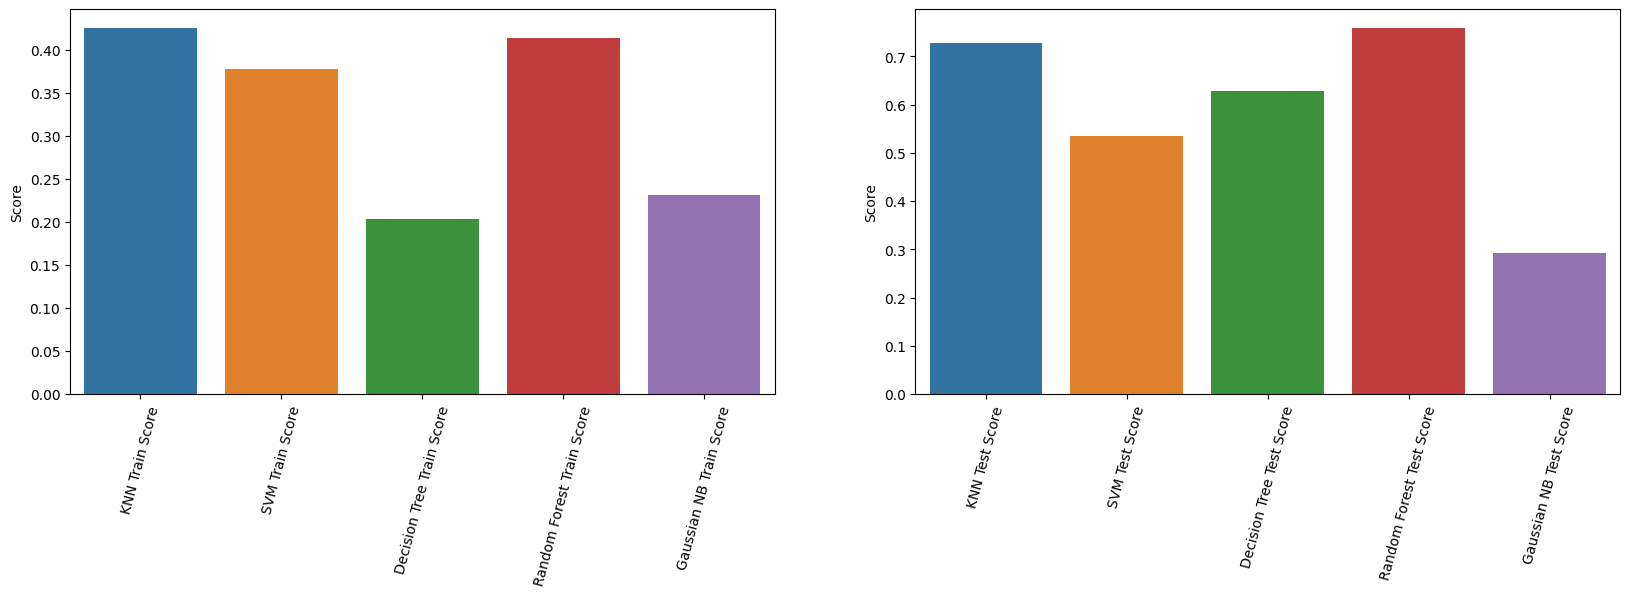

In [ ]:
df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index",columns=["Score"])
df_result_test
import seaborn as sns
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
plt.show()
